<a href="https://colab.research.google.com/github/aparnay2002/real-state-price-prediction/blob/main/%20real-state-price-prediction/Real_Estate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install findspark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession, SQLContext

     |████████████████████████████████| 281.4 MB 23 kB/s 
     |████████████████████████████████| 198 kB 48.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=29e23e91fedb2ff49beb344ea2ffd7ae4f1a811f8284aa23a256aa2616a047ef
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
#Initial
import os
import numpy as np
import pandas as pd
import math

#Spark
import pyspark as spark
from pyspark import SparkConf, SparkContext


sc = SparkContext.getOrCreate()


from pyspark.sql import SparkSession, SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor, GeneralizedLinearRegression, AFTSurvivalRegression
from pyspark.ml.feature import VectorIndexer

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
 
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder  
    
#Plots    
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
pdtrainset = pd.read_csv("./train.csv")

In [ ]:
pdtrainset.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
pdtrainset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
pdtrainset["SalePrice"] = np.log(pdtrainset["SalePrice"])
pdtrainset.head(7)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,11.870600
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.634603


In [ ]:
pdtrainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
correl = pdtrainset[1:].corr()
correl.drop(["SalePrice", "Id"], axis=1, inplace=True)

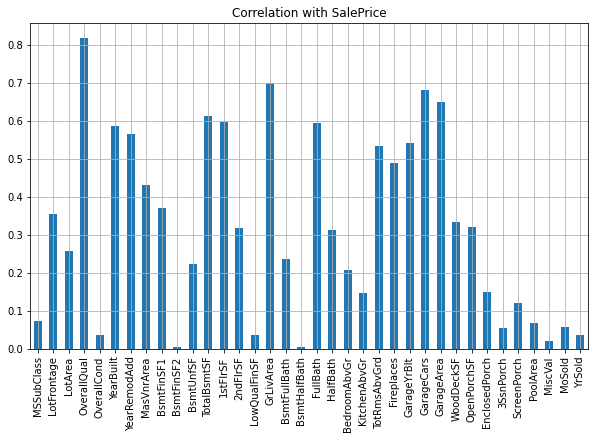

In [ ]:
correl.iloc[-1].apply(lambda x: abs(x)).plot(kind='bar', figsize=(10, 6), title="Correlation with SalePrice", grid=True)

In [ ]:
salecorrel = pd.DataFrame(correl.transpose()["SalePrice"])
top_features = salecorrel[salecorrel["SalePrice"] >= 0.45].sort_values(by=["SalePrice"], 
                                                                      ascending=False)
topcolumns = top_features.transpose().columns.values
topcorrelVal = top_features.values

["{0}: {1:.4f}".format(col, topcorrelVal[i][0]) for i,col in enumerate(topcolumns)]


['OverallQual: 0.8171',
 'GrLivArea: 0.7009',
 'GarageCars: 0.6806',
 'GarageArea: 0.6509',
 'TotalBsmtSF: 0.6124',
 '1stFlrSF: 0.5975',
 'FullBath: 0.5947',
 'YearBuilt: 0.5865',
 'YearRemodAdd: 0.5655',
 'GarageYrBlt: 0.5410',
 'TotRmsAbvGrd: 0.5343',
 'Fireplaces: 0.4900']

In [ ]:
# [sns.lmplot(x="SalePrice",y=x,data=pdtrainset,
#            scatter_kws={'alpha':0.07}, aspect=2, height=4) for x in topcolumns]

topItemsCorrelation = pdtrainset[list(topcolumns)].corr().abs()

topItemsCorrelation

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces
OverallQual,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684,0.547766,0.427452,0.396765
GrLivArea,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.199010,0.287389,0.231197,0.825489,0.461679
GarageCars,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622,0.588920,0.362289,0.300789
GarageArea,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600,0.564567,0.337822,0.269141
TotalBsmtSF,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066,0.322445,0.285573,0.339519
1stFlrSF,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379,0.233449,0.409516,0.410531
FullBath,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046,0.484557,0.554784,0.243671
YearBuilt,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855,0.825667,0.095589,0.147716
YearRemodAdd,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000,0.642277,0.191740,0.112581
GarageYrBlt,0.547766,0.231197,0.588920,0.564567,0.322445,0.233449,0.484557,0.825667,0.642277,1.000000,0.148112,0.046822


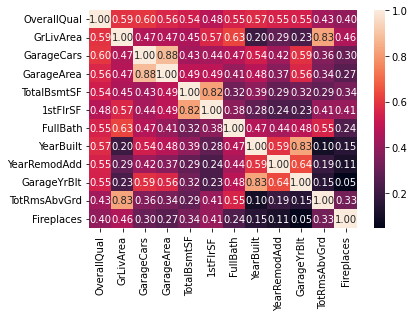

In [ ]:
sns.heatmap(topItemsCorrelation, annot=True, fmt=".2f")
plt.show()

In [ ]:
utcItems = pd.DataFrame(topItemsCorrelation.unstack(), columns=["c"])
utcItems[(utcItems["c"] > 0.8) & (utcItems["c"] < 1)]

,,c
GrLivArea,TotRmsAbvGrd,0.825489
GarageCars,GarageArea,0.882475
GarageArea,GarageCars,0.882475
TotalBsmtSF,1stFlrSF,0.819530
1stFlrSF,TotalBsmtSF,0.819530
YearBuilt,GarageYrBlt,0.825667
GarageYrBlt,YearBuilt,0.825667
TotRmsAbvGrd,GrLivArea,0.825489


In [ ]:
topcolumns = list(set(topcolumns) - set(["TotRmsAbvGrd", "GarageArea", "1stFlrSF", "GarageYrBlt"]))
topcolumns

['YearRemodAdd',
 'FullBath',
 'OverallQual',
 'GrLivArea',
 'YearBuilt',
 'Fireplaces',
 'TotalBsmtSF',
 'GarageCars']

In [ ]:
getDecades = lambda col: col.apply(lambda x: math.ceil(float(x) / 10)*10)

pdtrainset["YearBuilt"] = getDecades(pdtrainset["YearBuilt"])
pdtrainset["YearRemodAdd"] = getDecades(pdtrainset["YearRemodAdd"])
pdtrainset = pdtrainset[topcolumns+["SalePrice"]]
pdtrainset.head()

,YearRemodAdd,FullBath,OverallQual,GrLivArea,YearBuilt,Fireplaces,TotalBsmtSF,GarageCars,SalePrice
0,2010,2,7,1710,2010,0,856,2,12.247694
1,1980,2,6,1262,1980,1,1262,2,12.109011
2,2010,2,7,1786,2010,1,920,2,12.317167
3,1970,1,7,1717,1920,1,756,3,11.849398
4,2000,2,8,2198,2000,1,1145,3,12.429216


In [ ]:
valuableColumns = list(pdtrainset.columns.values)

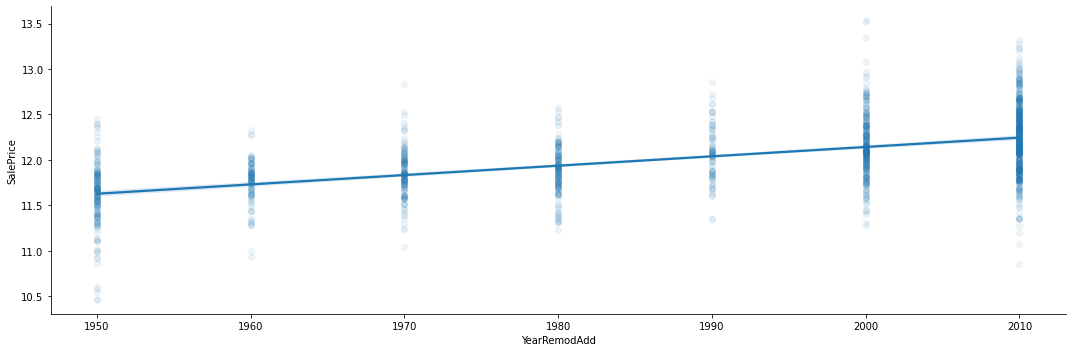

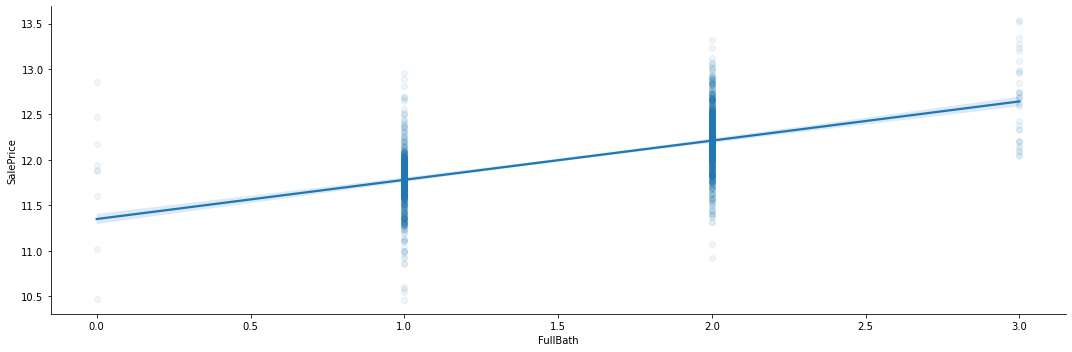

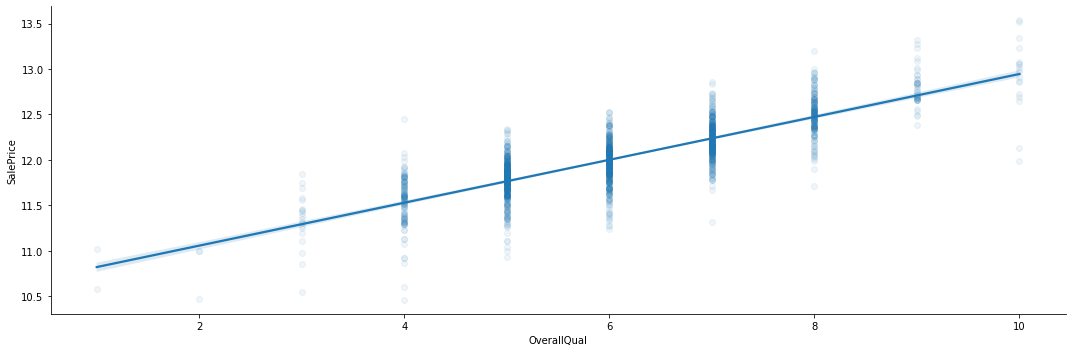

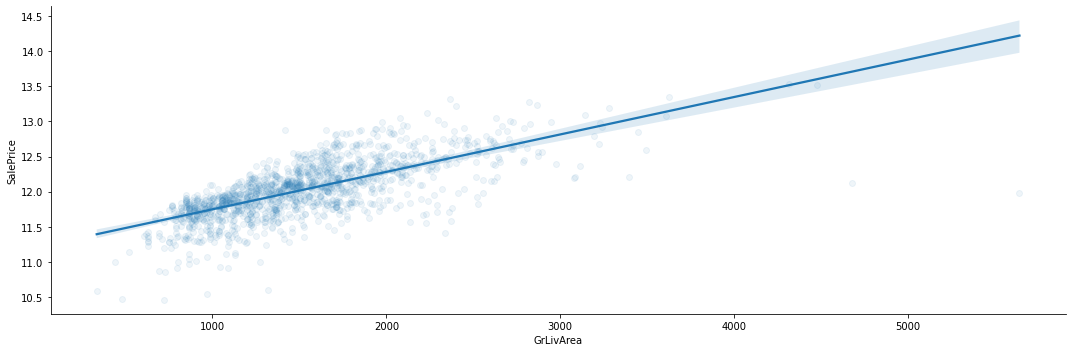

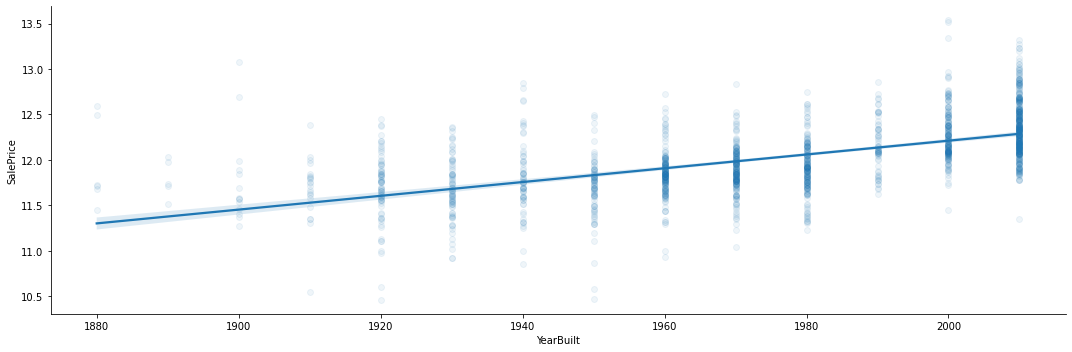

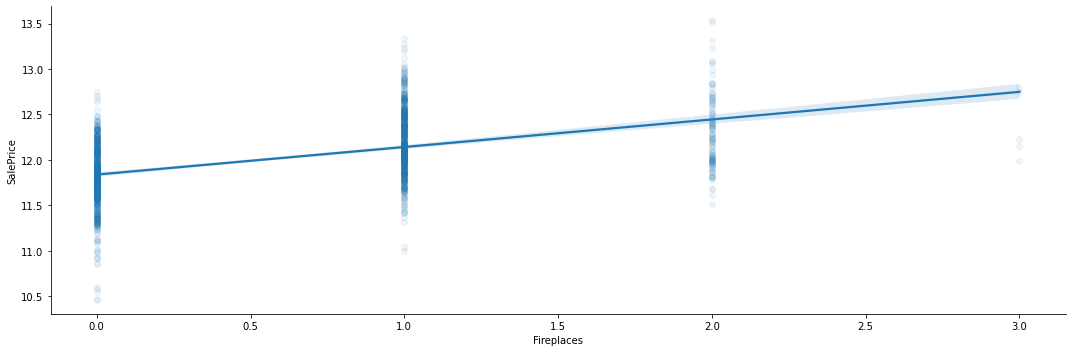

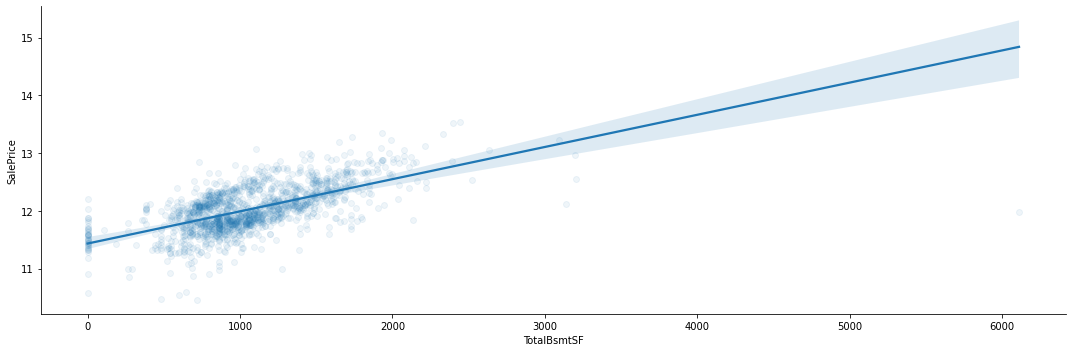

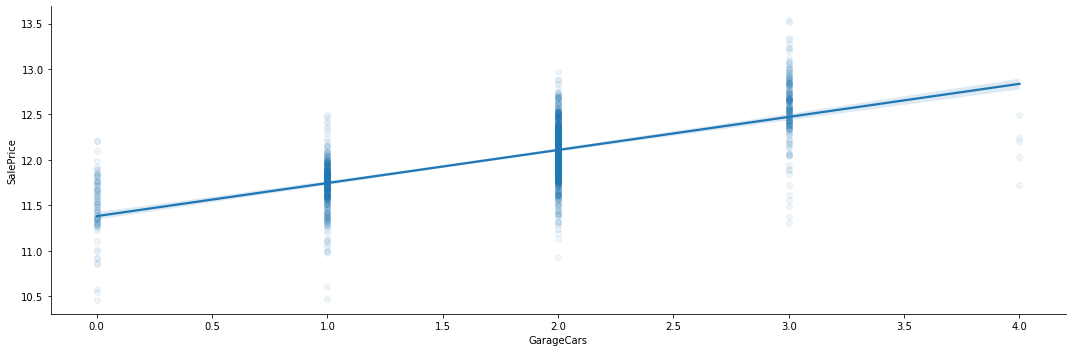

In [ ]:
[sns.lmplot(x=col,y="SalePrice",data=pdtrainset, 
            scatter_kws={'alpha':0.07}, aspect=3, height=5) for col in topcolumns]


In [ ]:
sqlContext = SQLContext(sc)

sc.setLogLevel("ERROR")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
df = sqlContext.createDataFrame(pdtrainset)

In [ ]:
df.describe()

DataFrame[summary: string, YearRemodAdd: string, FullBath: string, OverallQual: string, GrLivArea: string, YearBuilt: string, Fireplaces: string, TotalBsmtSF: string, GarageCars: string, SalePrice: string]

In [ ]:
# #sptrain = sqlContext.read.csv("../input/train.csv", header=True)

sptrain = df.withColumn("label", df.SalePrice.cast("double")).cache()

sptest = sqlContext.read.csv("./test.csv", header=True)

In [53]:
#let add few train model 
gbt = GBTRegressor(maxIter=100, 
                   maxDepth=5)\
                  .setLabelCol("label")\
                  .setFeaturesCol("features")

# Than let split our features on to group categorical (string) and continious (numerical)
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index")\
#             .setHandleInvalid("keep")\
#             .fit(sptrain) for column in catColumn]

#indexers = indexers + ([OneHotEncoder(inputCol= col+"_index", outputCol= col+"_oht") for col in catColumn])
#TODO: change all columns to a valuable only
indexers = []
indexers.append(VectorAssembler(
    inputCols=["{0}_d".format(col) for col in valuableColumns[:-1]], 
        outputCol="features"))
indexers.append(gbt)

In [54]:
(trainingData, subtestData) = sptrain.randomSplit([0.7, 0.3])

modelGBT = Pipeline(stages=tuple(indexers)).fit(trainingData)

In [55]:
predictions = modelGBT.transform(subtestData)

predictions.select(["prediction", "label", "features"]).show(7)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|11.232861057658367|11.134589024250317|[1950.0,1.0,4.0,5...|
|11.477714683208465|11.512925464970229|[1950.0,1.0,4.0,7...|
|11.251222379454667|11.314474526246391|[1950.0,1.0,4.0,8...|
|11.009496069407328|11.320553572322773|[1950.0,1.0,4.0,8...|
| 11.52986962415077|11.512925464970229|[1950.0,1.0,4.0,1...|
|11.617719048329844|10.596634733096073|[1950.0,1.0,4.0,1...|
|11.506118281256493| 11.37366339763672|[1950.0,1.0,5.0,8...|
+------------------+------------------+--------------------+
only showing top 7 rows



In [57]:
evaluator = RegressionEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {0}".format(str(rmse)))

Root Mean Squared Error (RMSE) on test data = 0.18243084238889046
